### Selecting dimensionality reduction with Pipeline and GridSearchCV

This example constructs a pipeline that does dimensionality reduction followed by prediction with a support vector classifier. It demonstrates the use of GridSearchCV and Pipeline to optimize over different classes of estimators in a single CV run – unsupervised PCA and NMF dimensionality reductions are compared to univariate feature selection during the grid search.
Additionally, Pipeline can be instantiated with the memory argument to memoize the transformers within the pipeline, avoiding to fit again the same transformers over and over.
Note that the use of memory to enable caching becomes interesting when the fitting of a transformer is costly.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', LinearSVC())
])

N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power = 7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim' : [SelectKBest(chi2)],
        'reduce_dim__k' : N_FEATURES_OPTIONS,
        'classify__C' : C_OPTIONS
    }
]

reducer_labels = ['PCA','NMF','KBest(chi2)']

grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
digits = load_digits()
grid.fit(digits.data, digits.target)


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'reduce_dim': [PCA(copy=True, iterated_power=7, n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
  n_components=8, nls_max_iter=2000, random_state=None, shuffle=False,
  solver='cd', sp...ction chi2 at 0x0000023547CFAB70>)], 'reduce_dim__k': [2, 4, 8], 'classify__C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [13]:
grid.best_estimator_
grid.best_score_
grid.best_params_ 
grid.best_index_ 
grid.scorer_ 
grid.n_splits_ 

3

In [14]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

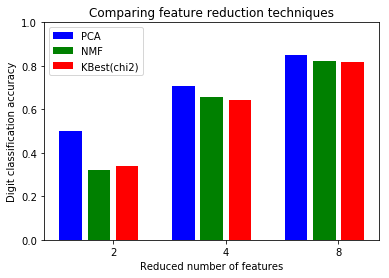

In [15]:
plt.show()